In [11]:
import re
import pandas as pd
from multiprocess import Pool
from functools import partial
import multiprocess as mp
import matplotlib.pyplot as plt

In [12]:
keywords = [
    "made in america", "made in u.s.", "made in us", # made in usa and made in us overlap
    "american made", "usa made", "u.s. made", "us made"
    "buy american", "buy usa", "buy america",
    "support america", "support usa", "support u.s.",
    "patriot",
    "choose american", "choose usa", "choose u.s.", "choose america",
    "national pride",
    "usa based", "america based", "american based", "us based", "u.s. based",
    "usa produced", "america produced", "american produced", "us produced", "u.s. produced",
    "usa manufactured", "america manufactured", "american manufactured", "us manufactured", "u.s. manufactured",
    "american worker", "american job",
    "veteran owned", "veteran founded", "founded by veteran",
    "handcrafted in america", "handcrafted in usa", "handcrafted in u.s.", "handcrafted in us",
    "crafted in america", "crafted in u.s.", "crafted in us", # removed "crafted in the usa" due to overlap with crafted in the US
    "america heritage", "america tradition", "america value",
    "icon of america", "icon of usa", "icon of u.s.",
    "america manufactur", "u.s. manufactur"
]


In [47]:
# df = pd.read_csv("about_us_second_round_with_additional_firms.csv", nrows=100, low_memory=False)
df = pd.read_csv("company_website_second_round_with_additional_firms.csv", nrows=100, low_memory=False)
 
def filter_columns(df):
    pattern = r"^\d{4}-\d{2}$"  # Regex to match the YYYY-MM format
    # Keep 'std_name' and any other column that matches the date format
    filtered_columns = ['std_name'] + [col for col in df.columns if re.match(pattern, col)]
    return df[filtered_columns]

df = filter_columns(df)
df = df.drop_duplicates(subset='std_name', keep='first').reset_index(drop=True)
df = df.sort_values(by='std_name').reset_index(drop=True)
df = df.drop(columns=['std_name'])
columns = list(df.columns)

In [48]:
df.sample(50)

,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01,...,1997-07,1997-06,1997-05,1997-04,1997-03,1997-02,1997-01,1996-12,1996-11,1996-10
25,NaN,NaN,\n Able\nSkip to content\nShop\nBasket - ...,NaN,NaN,\n Able\nSkip to content\nShop\nBasket - ...,NaN,\n Able\nSkip to content\nShop\nKone - Fi...,\n Able\nSkip to content\nShop\nKone - Fi...,\n Able\nSkip to content\nShop\nKone - Fi...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,\nAlec Bradley Cigars - Home\n\tWe are using m...,\nAlec Bradley Cigars - Home\n\tWe are using m...,NaN,NaN,NaN,\nAlec Bradley Cigars - Home\n\tWe are using m...,\nAlec Bradley Cigars - Home\n\tWe are using m...,\nAlec Bradley Cigars - Home\n\tWe are using m...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,\nAccel Lifestyle | Shop Clothing for Men & Wo...,NaN,NaN,\nAccel Lifestyle | Shop Clothing for Men & Wo...,NaN,\nAccel Lifestyle | Shop Clothing for Men & Wo...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,\n9B Apparel\n9B Apparel\nHOME\nDevelopment/Pr...,NaN,\n9B Apparel\n9B Apparel\nHOME\nDevelopment/Pr...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,\nHealthy Home Experts Since 1924 | Aerus\nCon...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,\n Alima Pure Mineral Makeup | All Natura...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,"\nKnives, Cooking Sets, Bakeware, Kitchen Gadg...",NaN,"\nKnives, Cooking Sets, Bakeware, Kitchen Gadg...",NaN,NaN,"\nKnives, Cooking Sets, Bakeware, Kitchen Gadg...",NaN,"\nKnives, Cooking Sets, Bakeware, Kitchen Gadg...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,\nUSA Built Saltwater Fishing Reels &amp; Gear...,NaN,\nUSA Built Saltwater Fishing Reels &amp; Gear...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,Home 21 & Over Under 21 View on Mobile,Home 21 & Over Under 21 View on Mobile,NaN,Home 21 & Over Under 21 View on Mobile,Home 21 & Over Under 21 View on Mobile,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,\n313 Bicycle Works - 313 Bicycle Works - Cust...,NaN,NaN,\n313 Bicycle Works - 313 Bicycle Works - Cust...,\n313 Bicycle Works - 313 Bicycle Works - Cust...,NaN,\n313 Bicycle Works - 313 Bicycle Works - Cust...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
def count_keywords_in_cell(cell, keywords):
    return sum(1 if keyword.lower() in str(cell).lower() else 0 for keyword in keywords)

def calculate_total_counts(df, columns, keywords):
    total_counts_df = pd.DataFrame(index=df.index, columns=columns, dtype=int).fillna(0)
    
    for index, row in df.iterrows():
        previous_count = 0  # Initialize the previous count
        for col_idx, col in enumerate(reversed(columns)):
            cell_value = row[col]
            current_count = count_keywords_in_cell(cell_value, keywords)
            
            # If the current count is zero and the previous count is greater than zero, use the previous count
            if current_count == 0 and previous_count > 0:
                total_counts_df.at[index, columns[len(columns) - 1 - col_idx]] = previous_count
            else:
                total_counts_df.at[index, columns[len(columns) - 1 - col_idx]] = current_count
                previous_count = current_count  # Update previous count
    
    return total_counts_df

In [50]:
total_counts_df = calculate_total_counts(df, columns, keywords)

In [51]:
document_counts = [0] * len(columns) # Initialize a list to hold the count of documents for each year.

for row in df.itertuples(index=False):# Iterate over each row in the DataFrame.
    previous_count = 0 # Initialize the previous count to 0 for the first iteration.

    for idx in reversed(range(len(columns))):    # Iterate over the columns in reverse order to update the document count.
        value = row[idx] # Access the value using the appropriate index for itertuples() output.
        
        # Check if the current cell has a document (non-NaN and not an empty string).
        if pd.isna(value) or isinstance(value, int):
            document_counts[idx] += previous_count # If there's a document, increment the count for the year and set the previous count to 1.
        else:
            document_counts[idx] += 1 # If there's no document, add the previous year's count to this year's count.
            previous_count = 1 # We have found a document so previous should never be 0



total_documents = sum(document_counts)
document_count_sum = total_documents
# Print the total number of documents.
print(total_documents)

# This number is less than other because the index column was included in previous calculations

16481


In [52]:
def count_term_existence(df, columns, total_counts_df, keyword):
    import pandas as pd
    print(f"Processing keyword: {keyword}")
    term_existence = [0] * len(columns)
    
    for index, row in df.iterrows():
        previous_total_count = 0  # Initialize the total count for all keywords in the previous cell
        for col_idx, col in enumerate(reversed(columns)):
            cell_value = row[col]
            current_total_count = total_counts_df.at[index, col]

            if current_total_count == 0 and previous_total_count > 0:
                # If total count drops to 0 but was higher before, carry over the previous value
                term_existence[len(columns) - 1 - col_idx] += 1
            elif pd.isna(cell_value) or isinstance(cell_value, int):
                term_existence[len(columns) - 1 - col_idx] += 0
            else:
                if keyword in cell_value.lower():
                    term_existence[len(columns) - 1 - col_idx] += 1
                else:
                    term_existence[len(columns) - 1 - col_idx] += 0

            if current_total_count == 0 and previous_total_count > 0:
                previous_total_count = previous_total_count
            else:
                previous_total_count = current_total_count  # Update the total count for the next iteration

    return {keyword: sum(term_existence)}

In [53]:
count_term_existence(df, columns, total_counts_df, 'made in america')

Processing keyword: made in america


{'made in america': 162}

In [54]:
func = partial(count_term_existence, df, columns, total_counts_df)

# Initialize multiprocessing Pool
with Pool(processes=4) as pool:
    # Map the function across the keywords
    results = pool.map(func, keywords)

# Combine the results
term_count = {}
for result in results:
    term_count.update(result)

print(term_count)

{'made in america': 162, 'made in u.s.': 1, 'made in us': 439, 'american made': 377, 'usa made': 85, 'u.s. made': 32, 'us madebuy american': 0, 'buy usa': 0, 'buy america': 0, 'support america': 0, 'support usa': 0, 'support u.s.': 0, 'patriot': 62, 'choose american': 0, 'choose usa': 0, 'choose u.s.': 0, 'choose america': 0, 'national pride': 0, 'usa based': 0, 'america based': 0, 'american based': 0, 'us based': 0, 'u.s. based': 0, 'usa produced': 0, 'america produced': 0, 'american produced': 0, 'us produced': 0, 'u.s. produced': 0, 'usa manufactured': 0, 'america manufactured': 0, 'american manufactured': 0, 'us manufactured': 1, 'u.s. manufactured': 0, 'american worker': 0, 'american job': 0, 'veteran owned': 0, 'veteran founded': 0, 'founded by veteran': 0, 'handcrafted in america': 4, 'handcrafted in usa': 0, 'handcrafted in u.s.': 0, 'handcrafted in us': 0, 'crafted in america': 4, 'crafted in u.s.': 0, 'crafted in us': 0, 'america heritage': 0, 'america tradition': 0, 'america

In [55]:
def generate_final_value_by_year(df, total_counts_df, columns, document_count_sum, data):
    import math
    import pandas as pd  # Ensure pandas is imported in the function's scope

    def count_keyword_in_cell(cell, keyword):
        return 1 if keyword.lower() in str(cell).lower() else 0

    def count_total_keywords(cell, keywords):
        return sum(count_keyword_in_cell(cell, kw) for kw in keywords)
    keyword, term_existence = data

    print("Processing keyword: ", keyword)
    term_existence_full = [0] * len(columns)

    if term_existence == 0: # Skip over if this term wasn't counted in any of the years
        return {keyword: term_existence_full}
    
    for index, row in df.iterrows():
        previous_value = 0
        previous_total_count = 0
        for col_idx, col in enumerate(reversed(columns)):
            cell_value = row[col]
            current_total_count = total_counts_df.at[index, col]

            if current_total_count == 0 and previous_total_count > 0:
                # If total count drops to 0 but was higher before, carry over the previous value
                term_existence_full[len(columns) - 1 - col_idx] += previous_value
            elif pd.isna(cell_value) or isinstance(cell_value, int):
                term_existence_full[len(columns) - 1 - col_idx] += 0
                previous_value = 0
            else:
                # if keyword in cell_value.lower():
                #     term_existence[len(columns) - 1 - col_idx] += 1
                # else:
                #     term_existence[len(columns) - 1 - col_idx] += 0


                keyword_count = row[col].lower().count(keyword) # This is the term frequency within this document (for not using TF-IDF)
                value = keyword_count # No changes to the value here! (for not using TF-IDF)

                term_existence_full[len(columns) - 1 - col_idx] += value
                previous_value = value

            if current_total_count == 0 and previous_total_count > 0:
                previous_total_count = previous_total_count
            else:
                previous_total_count = current_total_count  # Update the total count for the next iteration


    return {keyword: term_existence_full}

In [56]:
# Run this over all of the different keywords

func = partial(generate_final_value_by_year, df, total_counts_df, columns, document_count_sum)

# Use multiprocessing to map the keywords to the function
pool = mp.Pool(processes=6)
results = pool.map(func, ((keyword, term_count[keyword]) for keyword in keywords))

# Combine the results
tf_idf_total = {}
for result in results:
    tf_idf_total.update(result)

In [58]:
year_sums = [0] * len(columns)
for keyword in keywords: # Going through all of the keywords
    if type(tf_idf_total[keyword]) == int: # This is a redundant invalid check
        continue
    for column in range(len(columns)): # Go through all of the years
        year_sums[column] += tf_idf_total[keyword][column] # Adding up all the sums per year 
    
for column in range(len(columns)): 
    # print(column)
    # print(document_count[column])   
    # print(year_sums[column], document_count[column])

    try:
        year_sums[column] /= document_counts[column]
    except ZeroDivisionError:
        year_sums[column] /= 1
print(year_sums[:10])

[0.011363636363636364, 0.03409090909090909, 0.22727272727272727, 0.06818181818181818, 0.25, 0.07954545454545454, 0.10344827586206896, 0.3448275862068966, 0.1839080459770115, 0.16091954022988506]


In [59]:
company_website_year_sums = year_sums #RAN TODAY

In [60]:
company_website_year_sums_columns = columns # RAN TODAY

In [41]:
about_us_year_sums = year_sums

In [42]:
about_us_year_sums_columns = columns

In [64]:
# Create a DataFrame
df_final = pd.DataFrame({
    'year_month_day': [f"{ym}-01" for ym in about_us_year_sums_columns],
    'company_website_year_sums': company_website_year_sums,
    'about_us_year_sums': about_us_year_sums
})

# Add the combined column
df_final['combined'] = df_final['company_website_year_sums'] + df_final['about_us_year_sums']

print(df_final)

    year_month_day  company_website_year_sums  about_us_year_sums  combined
0       2023-10-01                   0.011364            0.000000  0.011364
1       2023-09-01                   0.034091            0.000000  0.034091
2       2023-08-01                   0.227273            0.103448  0.330721
3       2023-07-01                   0.068182            0.103448  0.171630
4       2023-06-01                   0.250000            0.620690  0.870690
..             ...                        ...                 ...       ...
320     1997-02-01                   0.000000            0.000000  0.000000
321     1997-01-01                   0.000000            0.000000  0.000000
322     1996-12-01                   0.000000            0.000000  0.000000
323     1996-11-01                   0.000000            0.000000  0.000000
324     1996-10-01                   0.000000            0.000000  0.000000

[325 rows x 4 columns]


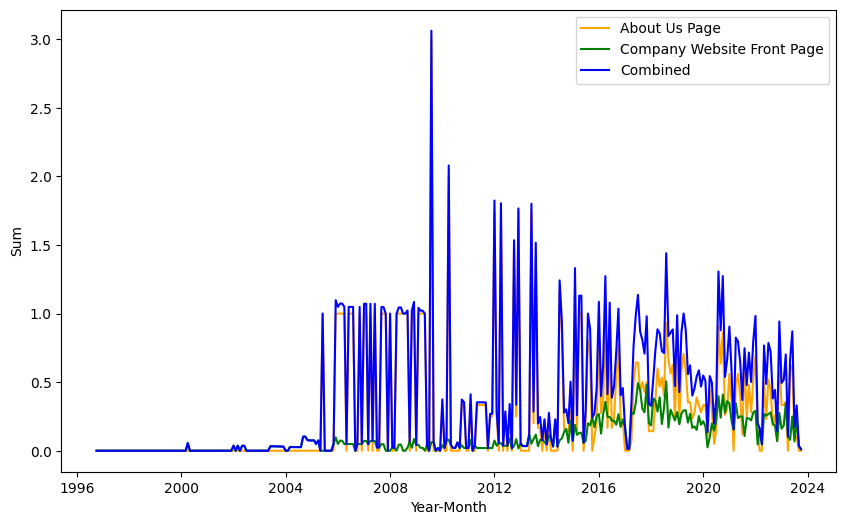

In [66]:
import matplotlib.pyplot as plt

# Plotting the data
df_final['year_month_day'] = pd.to_datetime(df_final['year_month_day'])

# Plotting the data with date formatting on the x-axis
plt.figure(figsize=(10, 6))

# Plot each series
plt.plot(df_final['year_month_day'], df_final['about_us_year_sums'], label='About Us Page', color='orange')
plt.plot(df_final['year_month_day'], df_final['company_website_year_sums'], label='Company Website Front Page', color='green')
plt.plot(df_final['year_month_day'], df_final['combined'], label='Combined', color='blue')

# Set labels for x and y axes
plt.xlabel('Year-Month')
plt.ylabel('Sum')

# Add legend
plt.legend()

# Show plot
plt.show()